## hough transform walkthrough:

#### imports:

In [1]:
#imports:
import numpy as np
import cv2

# specific functions
from matplotlib import pyplot as plt
from scipy.signal.windows import gaussian 

# import functions
from myImageFilter import myImageFilter
from myEdgeFilter import myEdgeFilter
from myHoughLines import myHoughLines
from myHoughTransform import myHoughTransform

from myHoughLines import *

### plotting fns

In [2]:
'''plotting a group of function: '''
def plot_images(images, rows, cols, titles=None, figsize=(20,7)):

    assert (len(images)==rows*cols)
    if titles:
        assert (len(images)==len(titles))

    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    axarr = np.array(axarr).reshape(-1) 

    for i, ax in enumerate(axarr):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        if titles:  
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [3]:
'''plotting a one function: '''
def printone(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
'''drawing lines on image --> based on houghscript.py'''
def draw_lines(img, rhos, thetas, rhoScale, thetaScale):
    img_lines = img.copy()
    for rho_ind, theta_ind in zip(rhos, thetas):
        a = np.cos(thetaScale[theta_ind])
        b = np.sin(thetaScale[theta_ind])
        x0 = a * rhoScale[rho_ind]
        y0 = b * rhoScale[rho_ind]
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
    return img_lines

In [5]:
'''drawing lines based on the houghscript.py'''
def draw_segments_on_image(img, lines):
    imgsegs = img.copy()
    for line in lines:
        x1,y1,x2,y2 = line
        cv2.line(imgsegs, (x1, y1), (x2, y2), \
                     (0, 255, 0), 1)
    
    return imgsegs

### reading images:

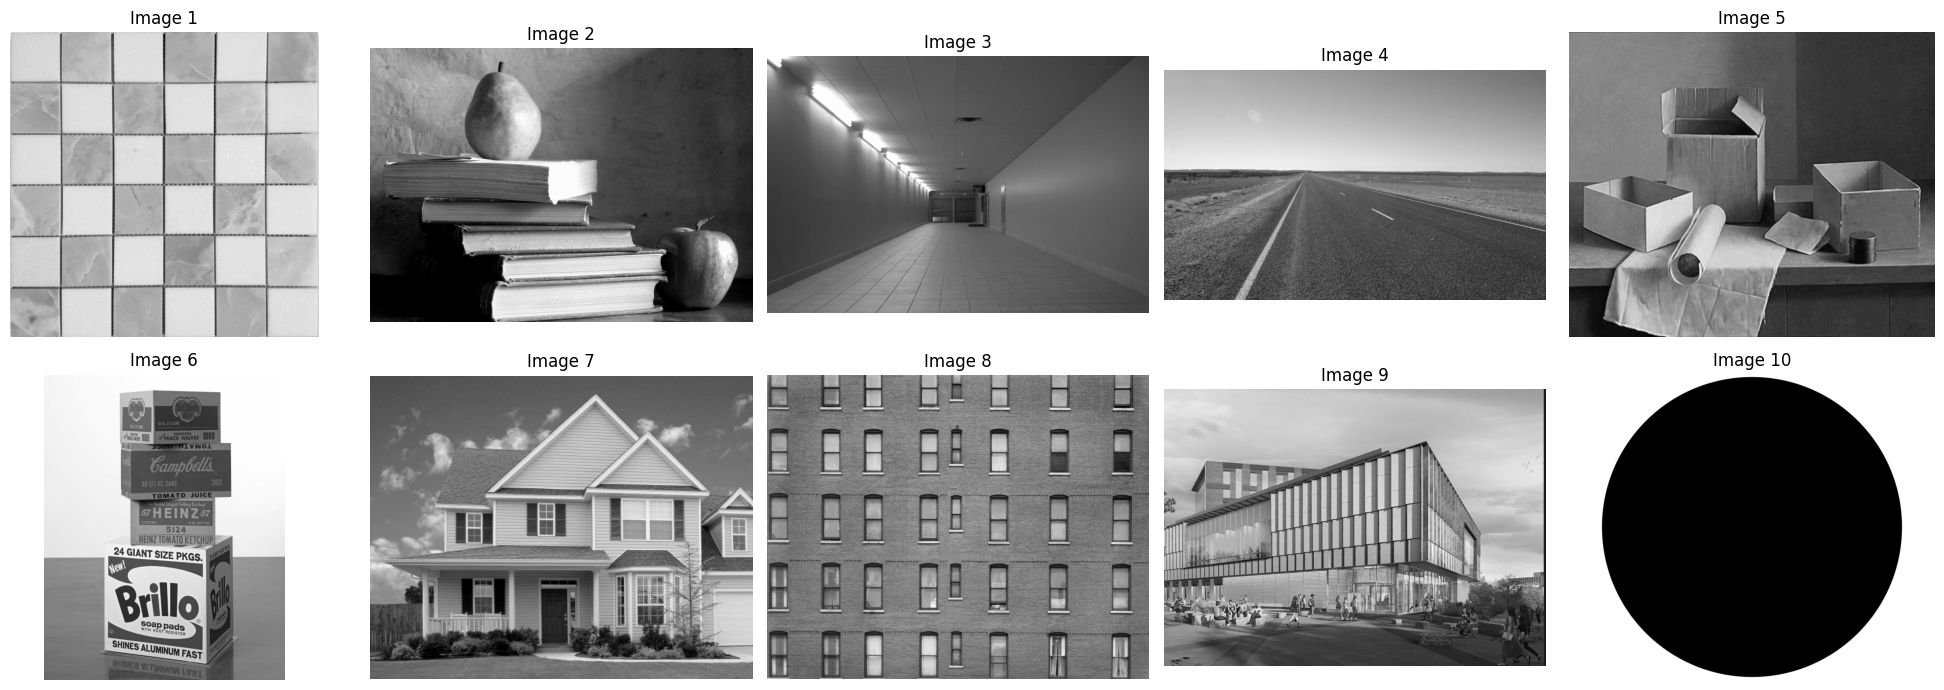

In [6]:
images = []
for i in range(1, 11):
    img = cv2.imread(f'../data/img{i:02}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)

titles = [f'Image {i}' for i in range(1,11)]

plot_images(images, 2, 5, titles)

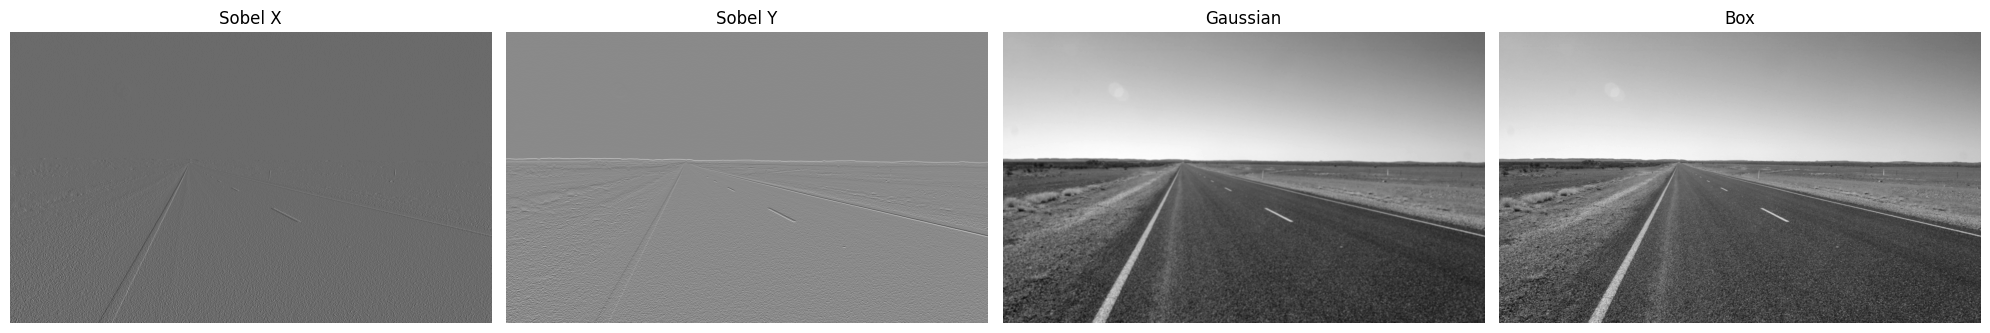

In [8]:
image = images[3]

sobelX = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
sobelY = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
gauss1D = gaussian(7, 3).reshape(7, 1)
gauss = gauss1D @ gauss1D.T
gauss = gauss/np.sum(gauss) # normalizing filter
box = np.ones(shape=(3,3))

kernels = [sobelX, sobelY, gauss, box]
kernels1 = [box]
titles = ['Sobel X', 'Sobel Y', 'Gaussian', 'Box']
filtered_images = [myImageFilter(image, kernel) for kernel in kernels] # call function on each kernel

plot_images(filtered_images, 1, 4, titles)

### edge detection

INPUT: image, sigma (param) \
OUTPUT: edges image

In [9]:
''' detecting edges:
        1. apply gaussian blue
        2. find sobel x and sobel y
        3. use sobel x and sobel y to find magnitude and direction
        4. using the direction apply NMS to decrease noise in magnitude
        5. output suppressed image '''

def myEdgeFilter(img0, sigma):
    # YOUR CODE HERE
    hsize = int(2 * np.ceil(3 * sigma) + 1)
    
    gauss1D = gaussian(hsize, sigma).reshape(hsize, 1)
    gauss = gauss1D @ gauss1D.T
    gauss = gauss/np.sum(gauss) # normalizing filter


    smoothimg = myImageFilter(img0, gauss)

    #np.fliplr(np.flipud(
    sobelX = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
    sobelY = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    
    imgx = myImageFilter(smoothimg, sobelX)
    imgy = myImageFilter(smoothimg, sobelY)

    imgmag = np.sqrt(imgx**2 + imgy**2) # vector magnitude?? setting different magnitudes??
    #imgmag = np.multiply(imgmag, 255.0 / imgmag.max())

    angles = np.rad2deg(np.arctan2(imgy, imgx)) # arctan based on coord -> turn into deg from radians
    angles[angles < 0] += 180 # weed out not under 180


    def non_maximum_suppression(image, angles):
        size = image.shape
        suppressed = np.zeros(size)
        for i in range(1, size[0] - 1):
            for j in range(1, size[1] - 1):
                if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):  #closest to 0 -> testing along x axis
                    value_to_compare = max(image[i, j - 1], image[i, j + 1])
                elif (22.5 <= angles[i, j] < 67.5):                              #closest to 45 -> testing along y = x
                    value_to_compare = max(image[i + 1, j + 1], image[i - 1, j - 1])
                elif (67.5 <= angles[i, j] < 112.5):                             #closest to 90 -> testing along y axis
                    value_to_compare = max(image[i - 1, j], image[i + 1, j])
                else:                                                            #closeset to 135 -> testing along y = -x
                    value_to_compare = max(image[i + 1, j - 1], image[i - 1, j + 1])
                
                if image[i, j] >= value_to_compare:
                    suppressed[i, j] = image[i, j]
                    
        #suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
        return suppressed

    img1 = non_maximum_suppression(imgmag, angles)
    

    return img1

In [10]:
''' use threshold to clean up the images '''
def threshold(img, threshold):
    thresholded_img = np.float32(img > threshold)
    
    return thresholded_img

### testing

parameters used: 
- sigma: 3
- threshold: 20 

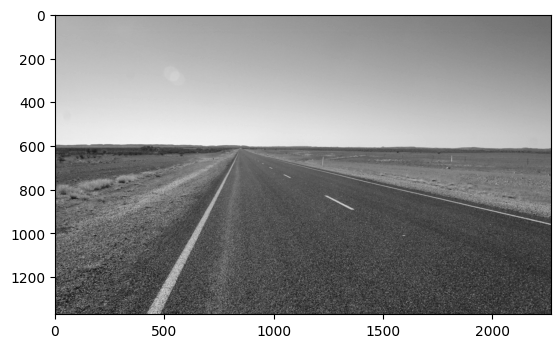

In [11]:
'''taking our one image to test'''
img = images[3]
printone(img)

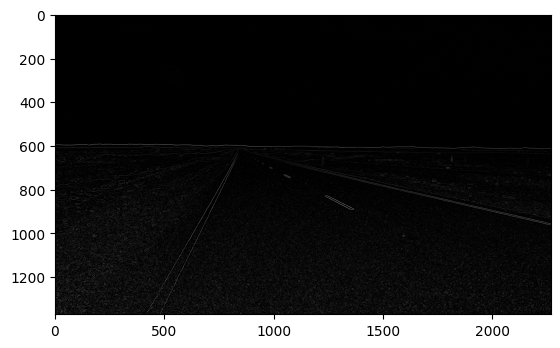

In [12]:
myEdgesimg = myEdgeFilter(img, 2) # compute list
printone(myEdgesimg)

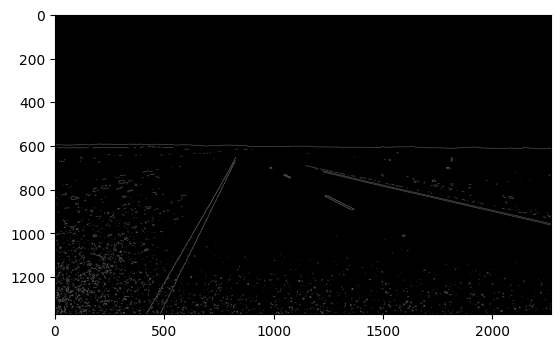

In [13]:
imgthreshold = np.float32(myEdgesimg > 50)
printone(imgthreshold)

### hough transform

INPUT: thresholded image, rhoRes (param), thetasRes (param) \
OUTPUT: hough image, rhoScale, thetaScale

In [14]:
def myHoughTransform(Im, rhoRes, thetaRes):
    h = Im.shape[0]
    w = Im.shape[1]
    
    # theta between [0, 2pi] incrementing by thetaRes
    thetamax = 2 * np.pi
    thetamin = 0
    thetaScale = np.arange(thetamin, thetamax, thetaRes)
    #print(len(thetaScale))
        
    # rho between [0, M] -- m is max distance in an image (diag)
    diaglen = int(np.sqrt(h**2 + w**2))
    rhoScale = np.arange(0, diaglen + 1, rhoRes)
    #print(len(rhoScale))
    
    # array for all sets of pairs
    imghough = np.zeros((len(rhoScale), len(thetaScale)), dtype=np.int32)
    
    # get edges -> thresh > 0
    edgepts = np.argwhere(Im > 0)
    
    for j, theta in enumerate(thetaScale):
        #if j % 10 == 0:
        #    print(j, theta)
        for y, x in edgepts:
            # p = x cos(t) + y sin(t)
            rho = x * np.cos(theta) + y * np.sin(theta)
            
            if rho >= 0: 
                rho_idx = np.argmin(np.abs(rhoScale - rho))
                
                imghough[rho_idx, j] += 1
    
    return imghough, rhoScale, thetaScale

### testing

parameters used:
- rhoRes = 2
- thetaRes = np.pi / 90

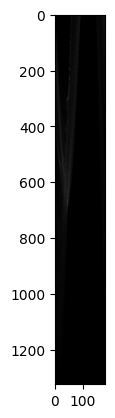

In [15]:
rhoRes = 2
thetaRes = np.pi / 90

img_hough, rhoScale, thetaScale = myHoughTransform(imgthreshold, rhoRes, thetaRes)

plt.imshow(img_hough, cmap='gray')

### hough lines

INPUT: transformed hough image, nLines (param) \
OUTPUTS: rhos, thetas --> used to draw the lines

In [16]:
def myHoughLines(H, nLines):

    #define a non max suppression for hough image
    def non_max_suppression(H):
        Hsup = np.zeros_like(H)
        rows, cols = H.shape
        
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                # take out a 3 by 3 area
                patch = H[i-1:i+2, j-1:j+2]
                
                # if center is max of 3x3, then set to middle
                if H[i, j] == np.max(patch):
                    Hsup[i, j] = H[i, j]
                else:
                    Hsup[i, j] = 0
                    
        return Hsup
    
    Hsup = non_max_suppression(H)

    rhos = []
    thetas = []
    
    for i in range(nLines):
        #find max in suppressed -> take the indexes
        idx = np.argmax(Hsup)
        rho_ind, theta_ind = np.unravel_index(idx, Hsup.shape)
        #add to list
        rhos.append(rho_ind)
        thetas.append(theta_ind)
        
        # set to 0 so we dont find the same line again
        Hsup[rho_ind, theta_ind] = 0
    
    return np.array(rhos), np.array(thetas)

### testing:

parameters used: 
- nLines = 15 

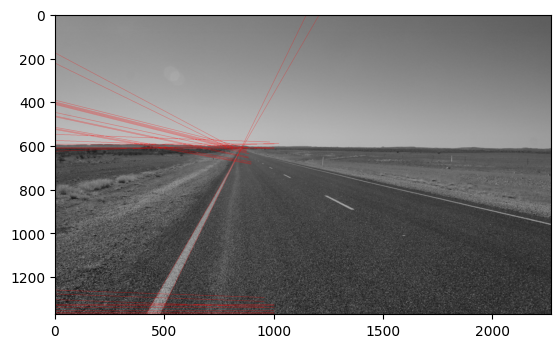

In [17]:

edges = imgthreshold

nLines = 30
rhos, thetas = myHoughLines(img_hough, nLines)

img_with_lines = draw_lines(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), rhos, thetas, rhoScale, thetaScale)

plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
plt.show()

### houghlinesP

In [20]:
def myHoughLineSegments(lineRho, lineTheta, rhoScale, thetaScale, Im, seglen=2, mindist=2): 
    h = Im.shape[0]
    w = Im.shape[1]
    lines = []

    rhoRes = 2
    thetaRes = np.pi / 90   
    
    for rho_idx, theta_idx in zip(lineRho, lineTheta):

        #variables
        rho = rhoScale[rho_idx]
        theta = thetaScale[theta_idx]

        cost = np.cos(theta)
        sint = np.sin(theta)
        
        #iterating through each pixel
        for y in range(h):
            for x in range(w):
                # if pixel is edge
                if Im[y, x] > 0:  
                    # pix dist from edge
                    dist = abs(x * cost + y * sint - rho)
                    
                    # dist close enough, cv2 has maxgap 5??
                    if dist < mindist:  
                        x0 = int(x - seglen * (-sint))
                        y0 = int(y - seglen * cost)
                        xn = int(x + seglen * (-sint))
                        yn = int(y + seglen * cost)

                        # add to lines
                        lines.append([x0, y0, xn, yn])
    
    return lines

### testing
parameters:
- seglen: 2 - default
- distance: 2 - default

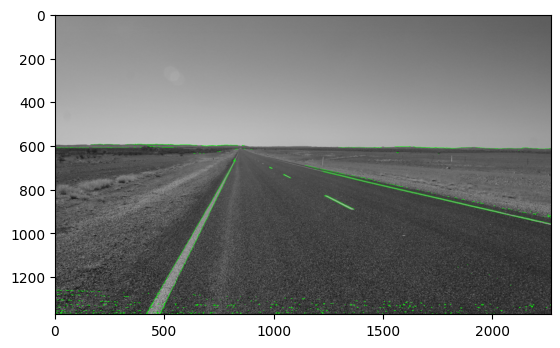

In [21]:
lines = myHoughLineSegments(rhos, thetas, rhoScale, thetaScale, edges)

imgsegs = draw_segments_on_image(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), lines)

plt.imshow(cv2.cvtColor(imgsegs, cv2.COLOR_BGR2RGB))
plt.show()